In [1]:
import numpy as np
import skeliner as sk

from pywarper.surface import fit_sac_surface, build_mapping
from pywarper.warpers import warp_skeleton
from pywarper.stats import get_convex_hull, get_hull_centroid, get_xy_center_of_mass


In [2]:
from pywarper.utils import read_sumbul_et_al_chat_bands
# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt", unit="physical") # should be the off sac layer
chat_bottom = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt", unit="physical") # should be the on sac layer
# but the image can be flipped
if chat_top["z"].mean() > chat_bottom["z"].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top
    
skel = sk.io.load_swc("../tests/data/Image013-009_01_raw_latest_Uygar.swc")
# in the original matlab code, all data were in voxel space and converted to microns at the end
# but it makes more sense to work in microns from the beginning, so that there will be fewer unit conversion in between
voxel_resolution = np.array([0.4, 0.4, 0.5])  # in microns
skel.nodes *= voxel_resolution


In [3]:
# Fit surfaces with pygridfit under the hood
off_sac_surface, xgridmax, ygridmax = fit_sac_surface(x=off_sac['x'], y=off_sac['y'], z=off_sac['z'], smoothness=15)
on_sac_surface,  xgridmin, ygridmin = fit_sac_surface(x=on_sac['x'], y=on_sac['y'], z=on_sac['z'], smoothness=15)

In [4]:
# fit quasi-conformally mapping
arbor_boundaries = np.array([skel.nodes[:, 0].min(), skel.nodes[:, 0].max(), skel.nodes[:, 1].min(), skel.nodes[:, 1].max()])
surface_mapping = build_mapping(on_sac_surface, off_sac_surface, arbor_boundaries, conformal_jump=2, n_anchors=16, verbose=True)

↳ mapping ON (min) surface …
    done in 0.06 seconds.
↳ mapping OFF (max) surface …
    done in 0.05 seconds.


In [5]:
# warp the arbor
warped_skel = warp_skeleton(skel, surface_mapping, conformal_jump=2, 
                z_profile_extends=[-25, 25], # extend the z profile by 25 microns in both directions, if None, it will be inferred.
                z_profile_nbins=120, # number of bins in the z profile, if None, it will be inferred.
                xy_profile_extends=[50, 300, 50, 300], # extend the xy profile by 300 microns in both directions, if None, it will be inferred.
                xy_profile_nbins=25, # number of bins in the xy profile, if None, it will be inferred.
                verbose=True)

[pywarper] Warping skeleton...
    done in 1.29 seconds.


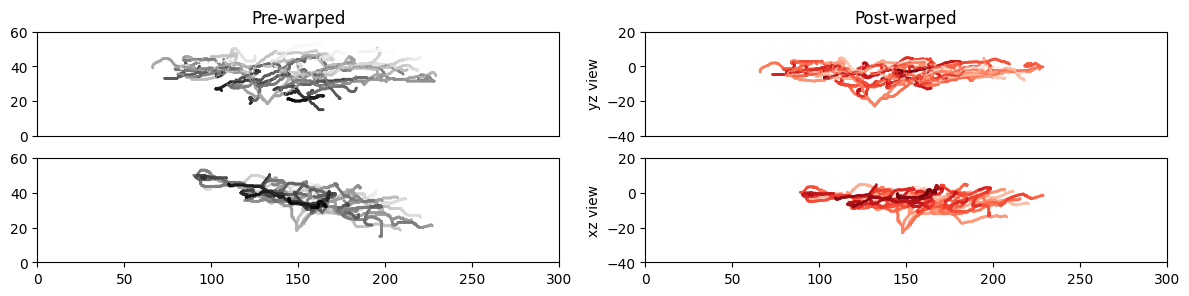

In [6]:
import matplotlib.pyplot as plt
mosaic = """
AB
CD
"""
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 3))

depth_order_pre = np.argsort(skel.nodes[:, 1])  # ascending (far → near)
sorted_nodes_pre = skel.nodes[depth_order_pre]  # scale to match the warped nodes

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_skel.nodes[:, 1])
sorted_nodes_post = warped_skel.nodes[depth_order_post]

# pre-warped
ax["A"].scatter(sorted_nodes_pre[:, 1], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 0], s=1, alpha=1, cmap="Grays")
ax["C"].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 1], s=1, alpha=1, cmap="Grays")
ax["A"].set_title("Pre-warped")

# post-warped
ax["B"].scatter(sorted_nodes_post[:, 1], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 0], s=1, alpha=1, cmap="Reds")
ax["D"].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 1], s=1, alpha=1, cmap="Reds")

ax["B"].set_ylabel("yz view")
ax["D"].set_ylabel("xz view")

ax["B"].set_title("Post-warped")

for i in ["A", "B", "C", "D"]:

    if i not in ['C', 'D']:
        ax[i].set_xticks([])
        
    if i in ['A', 'C']:
        ax[i].set_ylim(0, 60)

    if i not in ['A', 'C']:
        ax[i].set_ylim(-40, 20)

    ax[i].set_xlim(0, 300)

    ax[i].set_aspect('equal')
fig.tight_layout()

[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


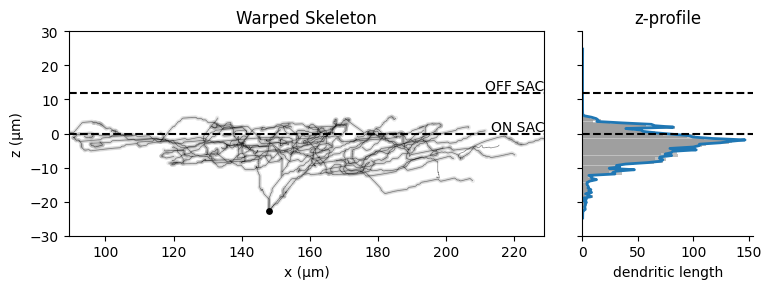

In [7]:
fig, (ax_nodes, ax_prof) = plt.subplots(
    1, 2,
    figsize=(8, 3),
    sharey=True,                 
    gridspec_kw={'width_ratios': [3, 1]}
)

# --- left: flattened arbor ----------------------------------------
sk.plot2d(warped_skel, plane="xz",
          ax=ax_nodes, color_by="ntype", skel_cmap="Set2",
          ylim=(-30, 30))
ax_nodes.set_xlabel('x (µm)')
ax_nodes.set_ylabel('z (µm)')
ax_nodes.set_title('Warped Skeleton')

# guide lines at ON / OFF SAC
for y in (0, 12):
    ax_nodes.axhline(y, ls='--', c='k')
ax_nodes.text(ax_nodes.get_xlim()[1], 0,
              'ON SAC', va='bottom', ha='right', fontsize=10)
ax_nodes.text(ax_nodes.get_xlim()[1], 12,
              'OFF SAC', va='bottom', ha='right', fontsize=10)

zprofile = warped_skel.extra["z_profile"]
z_dist = zprofile["distribution"]
x = zprofile["x"]
z_hist = zprofile["histogram"]
# --- right: depth profile (horizontal) ----------------------------
ax_prof.plot(z_dist, x, lw=2, c='tab:blue')
ax_prof.barh(x, z_hist, color="gray", alpha=0.5)
ax_prof.set_xlabel('dendritic length')
ax_prof.set_title('z-profile')
ax_prof.axhline(0,  ls='--', c='k')
ax_prof.axhline(12, ls='--', c='k')
ax_prof.set_ylim([-30, 30])

# remove unneeded spines to tidy the small panel
ax_prof.spines['top'].set_visible(False)
ax_prof.spines['right'].set_visible(False)

ax_nodes.set_aspect('equal') 
ax_prof.set_aspect('auto')

fig.tight_layout()
plt.show()

In [8]:
hull = get_convex_hull(warped_skel.nodes[:, 0:2])
com_hull = get_hull_centroid(hull)

xy_profile = warped_skel.extra["xy_profile"]
xy_dist = xy_profile["distribution"]
xy_x = xy_profile["x"]
xy_y = xy_profile["y"]
com_xy = get_xy_center_of_mass(xy_x, xy_y, xy_dist)

[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


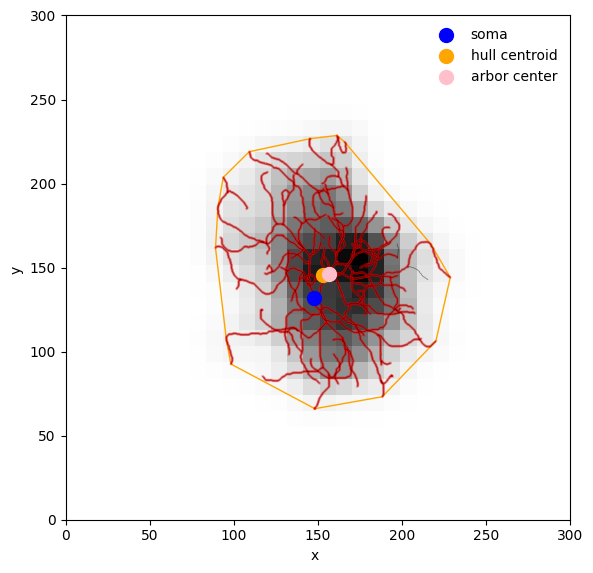

In [9]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(6, 6))



sk.plot2d(
    warped_skel, plane="xy", ax=ax, xlim=(0, 300), ylim=(0, 300),
)

ax.scatter(
    warped_skel.nodes[0, 0],
    warped_skel.nodes[0, 1],
    s=100, color='blue', zorder=99, label='soma',
)

ax.scatter(
    com_hull[0], com_hull[1],
    s=100, color='orange', zorder=99, label='hull centroid'
)

ax.scatter(
    com_xy[0], com_xy[1],
    s=100, color='pink', zorder=99, label='arbor center'
)

plt.fill(hull[:, 0], hull[:, 1], facecolor="none", edgecolor="orange", linewidth=1)

im = ax.imshow(
    xy_dist.T, origin="lower",
    extent=(xy_x[0], xy_x[-1], xy_y[0], xy_y[-1]),
    cmap="Greys", norm=Normalize(vmin=0, vmax=xy_dist.max()),
)

ax.legend(frameon=False)

In [10]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-06-16 15:11:48CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.3.0

matplotlib: 3.10.3
pywarper  : 0.2.0
skeliner  : 0.1.6
numpy     : 2.2.6

Watermark: 2.5.0

